In [48]:
import pandas as pd
import act
import os
import xarray as xr
import altair as alt
from sublimpy import utils
import rioxarray as rix

# Create wind field inputs

Cinnamon ridge data

In [49]:
file_path = '/Users/elischwat/Development/data/sublimationofsnow/CIN_11Aug2023/CIN_CR1000_Daily.dat'
file_path = '/Users/elischwat/Development/data/sublimationofsnow/CIN_11Aug2023/CIN_CR1000_lab_test.dat'

# Read the .dat file into a DataFrame
df = pd.read_csv(
    file_path, 
    skiprows=[0, 2, 3], 
)  # Adjust the delimiter if necessary

# Display the DataFrame
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.set_index('TIMESTAMP')
df = df[['WS_ms_AVG', 'AirTempC_Avg']].astype(float)
df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24179/3191030739.py:5: DtypeWarning: Columns (5,6,7,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,WS_ms_AVG,AirTempC_Avg
TIMESTAMP,,
2021-10-04 14:00:00,4.631,8.99
2021-10-04 14:15:00,3.674,9.44
2021-10-04 14:30:00,3.404,10.49
2021-10-04 14:45:00,3.747,9.77
2021-10-04 15:00:00,3.883,10.15
...,...,...
2023-08-11 13:30:00,5.858,11.76
2023-08-11 13:45:00,6.948,11.38
2023-08-11 14:00:00,4.365,11.94


<Axes: xlabel='TIMESTAMP'>

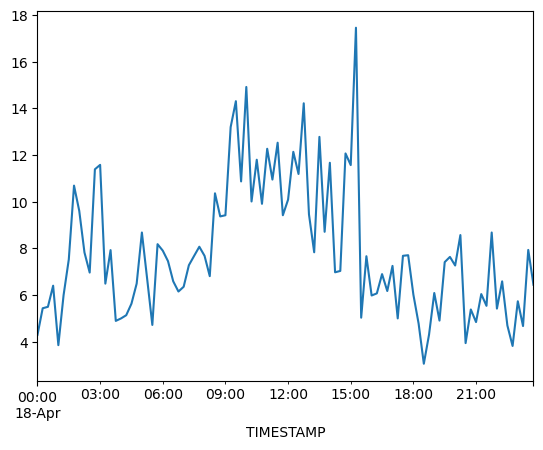

In [50]:
df.loc['20230418']['WS_ms_AVG'].plot()

Radiosonde data

In [51]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

In [52]:
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"

In [53]:
# Define the data code and date range
data_code = 'gucsondewnpnM1.b1'
start_date = '2023-04-18'
end_date = '2023-04-18'
# Download the data
files = act.discovery.download_arm_data(
    username,
    token,
    data_code,
    start_date,
    end_date,
    output = os.path.join(data_dir, "gucsondewnpnM1.b1")
)

[DOWNLOADING] gucsondewnpnM1.b1.20230418.113100.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20230418.232900.cdf

If you use these data to prepare a publication, please cite:

Keeler, E., Burk, K., & Kyrouac, J. Balloon-Borne Sounding System (SONDEWNPN),
2023-04-18 to 2023-04-18, ARM Mobile Facility (GUC), Gunnison, CO; AMF2 (main
site for SAIL) (M1). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1595321



In [54]:
sonde_morn = xr.open_dataset(os.path.join(os.path.join(data_dir, "gucsondewnpnM1.b1", "gucsondewnpnM1.b1.20230418.113100.cdf")))
sonde_day = xr.open_dataset(os.path.join(os.path.join(data_dir, "gucsondewnpnM1.b1", "gucsondewnpnM1.b1.20230418.232900.cdf")))

In [55]:
src_morn = sonde_morn.to_dataframe().query("alt < 5000")
src_day = sonde_day.to_dataframe().query("alt < 5000")

In [56]:
alt.Chart(src_morn).mark_line().encode(
    alt.X('wspd:Q'),
    alt.Y('alt:Q').scale(zero=False, nice=False, domain=[2900, 5000]),
    order='alt'
).properties(width=150, height = 300)

alt.Chart(...)

Doppler Lidar winds

In [57]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
start_date = "20230418"
end_date = "20230420"
DLWProf_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DLWProf_DATA_STREAM_FILEEXT = '.cdf'
DLWProf_OUTPUT_DIR = os.path.join(data_dir, DLWProf_DATA_STREAM)
file_list = act.discovery.download_arm_data(
            username, token, DLWProf_DATA_STREAM, start_date, end_date, output = DLWProf_OUTPUT_DIR)
dl_wprof = xr.open_mfdataset(file_list)

[DOWNLOADING] gucdlprofwind4newsM1.c1.20230418.001421.nc
[DOWNLOADING] gucdlprofwind4newsM1.c1.20230419.001420.nc

If you use these data to prepare a publication, please cite:

Shippert, T., Newsom, R., Riihimaki, L., & Zhang, D. Doppler Lidar Horizontal
Wind Profiles (DLPROFWIND4NEWS), 2023-04-18 to 2023-04-20, ARM Mobile Facility
(GUC), Gunnison, CO; AMF2 (main site for SAIL) (M1). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1178582



In [58]:
dl_wprof_df = dl_wprof.to_dataframe().reset_index()
dl_wprof_df['time'] = dl_wprof_df['time'].dt.round('15min')
dl_wprof_df = utils.modify_df_timezone(dl_wprof_df, 'UTC', 'US/Mountain')
dl_wprof_df = dl_wprof_df.set_index('time').loc['20230418': '20230418'].reset_index()

In [59]:
alt.Chart(
    pd.concat([
            dl_wprof_df.query("height > 250").query("height < 500").groupby("time").mean().reset_index(),
            dl_wprof_df.query("height > 1000").query("height < 1200").groupby("time").mean().reset_index(),
    ])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('mean(wind_speed):Q'),
    alt.Color('height:O').bin(step=250).scale(scheme='viridis')
).properties(width=600)

alt.Chart(...)

In [60]:
alt.Chart(
    pd.concat([
            dl_wprof_df.query("height > 250").query("height < 500").groupby("time").mean().reset_index(),
            dl_wprof_df.query("height > 1000").query("height < 1200").groupby("time").mean().reset_index(),
    ])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('mean(wind_direction):Q'),
    alt.Color('height:O').bin(step=250).scale(scheme='viridis')
).properties(width=600)

alt.Chart(...)

In [61]:
ls -lah | grep .nc

# Save a dataset

In [69]:
src = dl_wprof_df.set_index('time').loc['20230418 1740': '20230418 1750'].groupby('height').mean()
src.to_csv('winds_inputs.csv')

In [70]:
pd.read_csv('winds_inputs.csv',)

,height,bound,base_time,time_offset,time_bounds,scan_duration,elevation_angle,nbeams,u,u_error,...,met_spr,met_spr_min,met_spr_max,met_dt,met_lat,met_lon,met_alt,lat,lon,alt
0,98.66773,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,1.310092,1.268105,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
1,126.85851,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,-1.547050,2.200686,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
2,155.04929,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,-2.493489,1.870625,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
3,183.24007,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,-1.755747,1.604409,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
4,211.43085,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,-1.139941,1.103426,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,3509.75220,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,NaN,NaN,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
122,3537.94290,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,NaN,NaN,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
123,3566.13380,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,NaN,NaN,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
124,3594.32450,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,28.621471,3.105356,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0


Extract elevation profile!

In [71]:
elevation = rix.open_rasterio('/Users/elischwat/Downloads/UG_dem_3m_v1.tif')

In [72]:
elevation_30 = elevation.rio.reproject(
    elevation.rio.crs,
    resolution = (30,30)
)

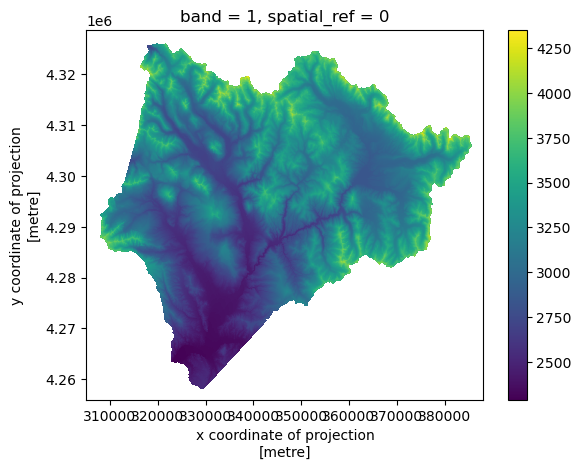

In [73]:
elevation_30.plot()

In [74]:
from sublimpy import extrautils
# Get the doppler lidar location
lon = dl_wprof[['lat', 'lon']].to_dataframe().drop_duplicates().lon.values[0]
lat = dl_wprof[['lat', 'lon']].to_dataframe().drop_duplicates().lat.values[0]

In [75]:
import geopy, py3dep, shapely.geometry, geopandas as gpd, numpy as np, rasterio

In [76]:
radius=6
bearing=90
n_points=6001
dem_file = '/Users/elischwat/Downloads/UG_dem_3m_v1.tif'

In [77]:
# Create the line from the radar lat, lon point
radar_location = geopy.Point(lat, lon)
radar_elevation = py3dep.elevation_bycoords(
    [(radar_location.longitude, radar_location.latitude)]
)

positive_distance = geopy.distance.distance(
    kilometers=radius
).destination(
    point=radar_location, 
    bearing=bearing
)
negative_distance = geopy.distance.distance(
    kilometers=radius
).destination(
    point=radar_location, 
    bearing=bearing-180
)
line = shapely.geometry.LineString([
    shapely.geometry.Point(negative_distance.longitude, negative_distance.latitude),
    shapely.geometry.Point(radar_location.longitude, radar_location.latitude),
    shapely.geometry.Point(positive_distance.longitude, positive_distance.latitude),
    
])
line = gpd.GeoDataFrame(geometry=[line]).set_crs('EPSG:4326').to_crs('EPSG:32613').geometry.iloc[0]


# Get the radar elevation value
radar_location = geopy.Point(lat, lon)
radar_elevation = py3dep.elevation_bycoords(
    [(radar_location.longitude, radar_location.latitude)]
)
radar_location, radar_elevation


# Create the line from the DEM data
distances = np.linspace(0, line.length, n_points)
points = [line.interpolate(distance) for distance in distances]
line = gpd.GeoDataFrame(geometry=[shapely.geometry.LineString(points)]).set_crs('EPSG:32613').geometry.iloc[0]
points = list(line.coords)
dem = rasterio.open(dem_file)
elevation_profile = rasterio.sample.sample_gen(dem, points)
elevation_profile = [f[0]-radar_elevation for f in elevation_profile]

result = pd.DataFrame({
    'elevation': elevation_profile,
    'distance': pd.Series(distances) - radius*1000
})


In [96]:
alt.data_transformers.disable_max_rows()
profile_plot = alt.Chart(result).mark_line(color='black', strokeWidth=2.5).encode(
    alt.X('distance:Q').scale(domain=[-6000,6000]).title('Distance from doppler lidar (m)'),
    alt.Y('elevation').scale(domain=[0,2000]).title('Height relative to doppler lidar (m)')
).properties(
    width=800,
    height=133
)
profile_plot

alt.Chart(...)

In [97]:
result.to_csv('profile_inputs.csv')

In [109]:
result.distance.diff()

0            NaN
1       1.999931
2       1.999931
3       1.999931
4       1.999931
          ...   
5996    1.999931
5997    1.999931
5998    1.999931
5999    1.999931
6000    1.999931
Name: distance, Length: 6001, dtype: float64

In [106]:
result.set_index('distance').rename(columns={'elevation':'data'}).to_xarray().to_netcdf('profile.nc')

In [107]:
result.set_index('distance').rename(columns={'elevation':'data'}).to_xarray()

<xarray.Dataset> Size: 96kB
Dimensions:   (distance: 6001)
Coordinates:
  * distance  (distance) float64 48kB -6e+03 -5.998e+03 ... 5.998e+03 6e+03
Data variables:
    data      (distance) float64 48kB 109.0 110.7 112.6 ... 942.0 942.0 943.9

In [98]:
ls | grep csv

profile_inputs.csv
winds_inputs.csv


In [99]:
winds = pd.read_csv('winds_inputs.csv')
winds

,height,bound,base_time,time_offset,time_bounds,scan_duration,elevation_angle,nbeams,u,u_error,...,met_spr,met_spr_min,met_spr_max,met_dt,met_lat,met_lon,met_alt,lat,lon,alt
0,98.66773,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,1.310092,1.268105,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
1,126.85851,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,-1.547050,2.200686,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
2,155.04929,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,-2.493489,1.870625,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
3,183.24007,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,-1.755747,1.604409,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
4,211.43085,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,-1.139941,1.103426,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,3509.75220,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,NaN,NaN,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
122,3537.94290,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,NaN,NaN,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
123,3566.13380,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,NaN,NaN,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0
124,3594.32450,0.5,2023-04-18,2023-04-18 23:44:20.925577984,2023-04-18 23:44:20.925578752,36.055756,70.0,8.0,28.621471,3.105356,...,0.0,0.0,0.0,300.0,38.956158,-106.987854,2886.0,38.9561,-106.98783,2886.0


In [100]:
winds_chart = alt.Chart(winds.query("height <= 2000")).mark_line(color='red').encode(
    alt.X('wind_speed:Q').scale(domain=[-100, 100]).axis(
        values=[0,5,10,15,20],
        domainColor='red',
        titleColor='red',
        labelColor='red',
        tickColor='red',
        grid=False
),
    alt.Y('height:Q'),
    order='height'
)
winds_chart

alt.Chart(...)

In [101]:
(profile_plot + winds_chart).resolve_scale(x='independent').configure_view(
    strokeOpacity=0
).display(renderer='svg')

alt.LayerChart(...)

In [102]:
elevation_profile

[109.04541015625,
 110.671875,
 112.579833984375,
 112.579833984375,
 114.640869140625,
 116.553955078125,
 116.553955078125,
 118.275146484375,
 120.142578125,
 120.142578125,
 121.969970703125,
 123.988525390625,
 123.988525390625,
 125.853515625,
 127.78515625,
 127.78515625,
 129.639892578125,
 131.529541015625,
 131.529541015625,
 133.435791015625,
 135.3916015625,
 135.3916015625,
 137.15478515625,
 138.673828125,
 138.673828125,
 140.39453125,
 142.00048828125,
 142.00048828125,
 143.814697265625,
 145.4873046875,
 145.4873046875,
 147.2509765625,
 149.004150390625,
 149.004150390625,
 150.239013671875,
 151.49365234375,
 151.49365234375,
 152.840576171875,
 154.078125,
 154.078125,
 155.17529296875,
 156.1298828125,
 156.1298828125,
 157.19482421875,
 158.257080078125,
 158.423583984375,
 159.41015625,
 160.26123046875,
 160.26123046875,
 161.141357421875,
 161.52197265625,
 161.52197265625,
 162.486083984375,
 164.082275390625,
 164.082275390625,
 165.843505859375,
 167.525878